In [1]:
% matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss

import gsw as sw
from mpl_toolkits.basemap import Basemap, cm, interp

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})

/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# import data

maxlon = 171
minlon = 129

Tok1 = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/Tokyo1_vSept16.csv', sep = ',')
Tok1['density'] = sw.rho(Tok1['S'].values,Tok1['T'].values,0)
#Tok1 = Tok1[(Tok1['Lon']>minlon) & (Tok1['Lon']<maxlon)]

Tok1['dlat'] = np.insert(np.diff(Tok1['Lat']), 0, 0)
Tok1 = Tok1[np.abs(Tok1['dlat'])<0.08]


Tok3 = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/Tokyo3_vSept16.csv', sep = ',')
Tok3['density'] = sw.rho(Tok3['S'].values,Tok3['T'].values,0)
#Tok3 = Tok3[(Tok3['Lon']>minlon) & (Tok3['Lon']<maxlon)]

Tian = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/Tianjin2_vSept16.csv', sep = ',')
Tian['density'] = sw.rho(Tian['S'].values,Tian['T'].values,0)
#Tian = Tian[(Tian['Lon']>minlon) & (Tian['Lon']<maxlon)]

print Tian.columns

Index([u'Timestamp', u'Lat', u'Lon', u'S', u'T', u'Fluo', u'TrueO2Ar',
       u'O2Arsat', u'O2Arbiosat', u'MLD (WOA13)', u'Wkn', u'Air-sea flux',
       u'density'],
      dtype='object')


/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


estimated calibration slope =  0.881930448676 , r =  0.869576623274 , p-value < 0.05  True


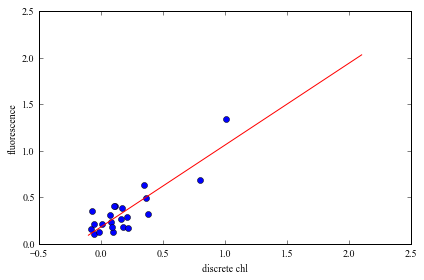

In [3]:
# import calibration data

calib = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/Discrete_ChlO2Ar_ForSophie.csv', sep = ',')

calib = calib.dropna()
#calib = calib[(calib['Lon']>minlon) & (calib['Lon']<maxlon)]

subTok1 = calib[calib['Cruise ID']=='Tokyo_1']
subTok1['Fluo'] = np.interp(subTok1['Date/Time'],Tok1['Timestamp'], Tok1['Fluo'],left=np.nan, right=np.nan, period=None)
subTok1 = subTok1.dropna()

plt.plot(subTok1['Fluo'],subTok1['[Chl] (ug/L)'], 'o')
plt.xlabel('discrete chl')
plt.ylabel('fluorescence')

mT,cT, rT, pT, std_errT = ss.linregress(subTok1['Fluo'],subTok1['[Chl] (ug/L)'])
plt.plot(np.arange(-0.1, 2.2, 0.1), mT*(np.arange(-0.1, 2.2, 0.1))+cT, 'r')

print 'estimated calibration slope = ', mT, ', r = ', rT, ', p-value < 0.05 ', pT<0.05

plt.show()

# calibrate fluorescence for Tokyo_1

Tok1['chl'] = mT*Tok1['Fluo']+cT

estimated calibration slope =  0.277163161943 , r =  0.795459956321 , p-value < 0.05  True


/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


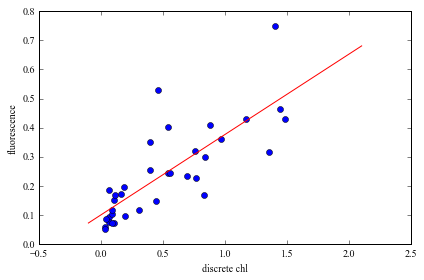

In [4]:
# import calibration data
subTok3 = calib[calib['Cruise ID']=='Tokyo_3']
subTok3['Fluo'] = np.interp(subTok3['Date/Time'],Tok3['Timestamp'], Tok3['Fluo'],left=np.nan, right=np.nan, period=None)
subTok3 = subTok3.dropna()

plt.plot(subTok3['Fluo'], subTok3['[Chl] (ug/L)'], 'o')
plt.xlabel('discrete chl')
plt.ylabel('fluorescence')

mT,cT, rT, pT, std_errT = ss.linregress(subTok3['Fluo'], subTok3['[Chl] (ug/L)'])
plt.plot(np.arange(-0.1, 2.2, 0.1), mT*(np.arange(-0.1, 2.2,0.1))+cT, 'r')

print 'estimated calibration slope = ', mT, ', r = ', rT, ', p-value < 0.05 ', pT<0.05

plt.show()

Tok3['chl'] = mT*Tok3['Fluo']+cT

estimated calibration slope =  0.704287683703 , r =  0.920385867265 , p-value < 0.05  True


/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


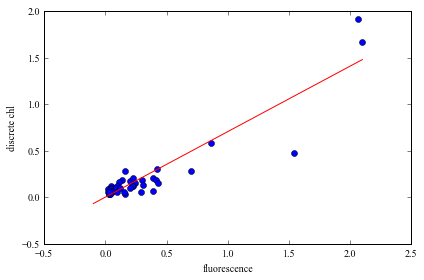

In [5]:
# import calibration data


subT = calib[calib['Cruise ID']=='Tianjin_2']
subT['Fluo'] = np.interp(subT['Date/Time'],Tian['Timestamp'], Tian['Fluo'], left=np.nan, right=np.nan, period=None)
subT = subT.dropna()

plt.plot(subT['Fluo'], subT['[Chl] (ug/L)'],'o')
plt.ylabel('discrete chl')
plt.xlabel('fluorescence')

mT,cT, rT, pT, std_errT = ss.linregress(subT['Fluo'], subT['[Chl] (ug/L)'])
plt.plot(np.arange(-0.1, 2.2, 0.1), mT*(np.arange(-0.1, 2.2, 0.1))+cT, 'r')

print 'estimated calibration slope = ', mT, ', r = ', rT, ', p-value < 0.05 ', pT<0.05

plt.show()

Tian['chl'] = mT*Tian['Fluo']+cT

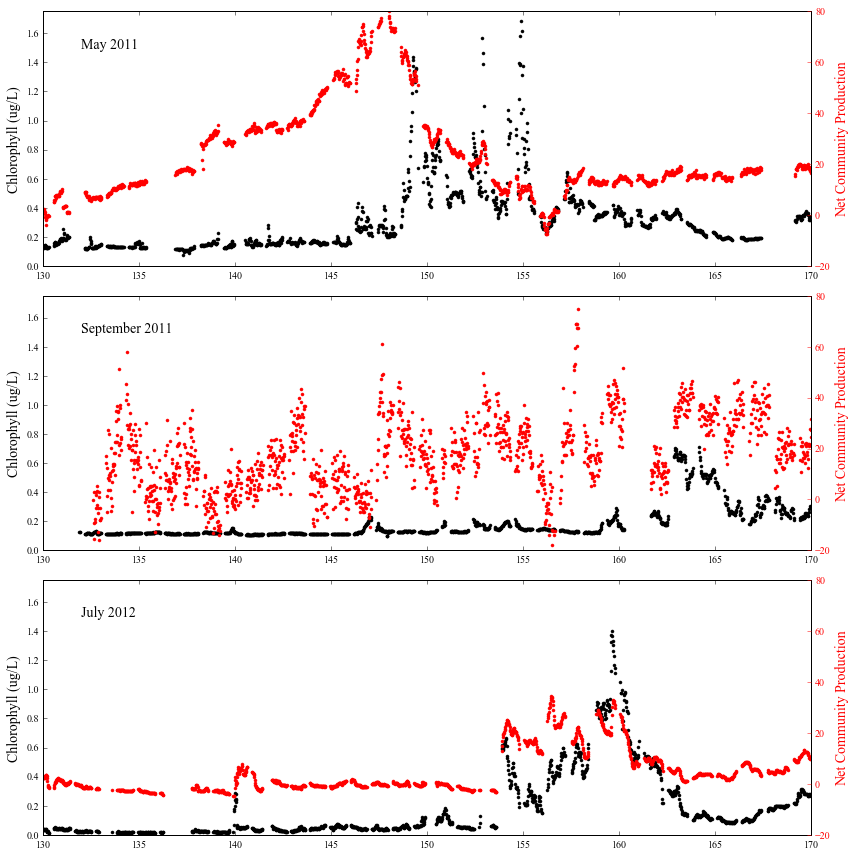

In [6]:
fig2, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (12, 12), dpi = 300)

ax1.plot(Tok1['Lon'], Tok1['chl'], '.k')
ax4 = ax1.twinx()
ax4.plot(Tok1['Lon'], Tok1['Air-sea flux'], '.r')
ax1.set_xlim([130, 170])
ax1.set_ylim([0, 1.75])
ax4.set_ylim([-20, 80])
ax1.text(132, 1.5,'May 2011', fontsize = 14)

ax1.set_ylabel('Chlorophyll (ug/L)', color='k', fontsize = 14)
ax4.set_ylabel('Net Community Production', color= 'r', fontsize = 14)
ax4.tick_params(colors='r')

ax2.plot(Tok3['Lon'], Tok3['chl'], '.k')
ax5 = ax2.twinx()
ax5.plot(Tok3['Lon'], Tok3['Air-sea flux'], '.r')
ax2.set_xlim([130, 170])
ax2.set_ylim([0, 1.75])
ax5.set_ylim([-20, 80])
ax2.text(132, 1.5,'September 2011', fontsize = 14)

ax2.set_ylabel('Chlorophyll (ug/L)', color='k', fontsize = 14)
ax5.set_ylabel('Net Community Production', color= 'r', fontsize = 14)
ax5.tick_params(colors='r')

ax3.plot(Tian['Lon'], Tian['chl'], '.k')
ax6 = ax3.twinx()
ax6.plot(Tian['Lon'], Tian['Air-sea flux'], '.r')
ax3.set_xlim([130, 170])
ax3.set_ylim([0, 1.75])
ax6.set_ylim([-20, 80])
ax3.text(132, 1.5,'July 2012', fontsize = 14)

ax3.set_ylabel('Chlorophyll (ug/L)', color='k', fontsize = 14)
ax6.set_ylabel('Net Community Production', color= 'r', fontsize = 14)
ax6.tick_params(colors='r')
ax6.set_xlabel('Longitude', fontsize = 14)

plt.show()

#fig2.savefig('../figures/uway_NCP_Chl_MJS.png', dpi = 300)

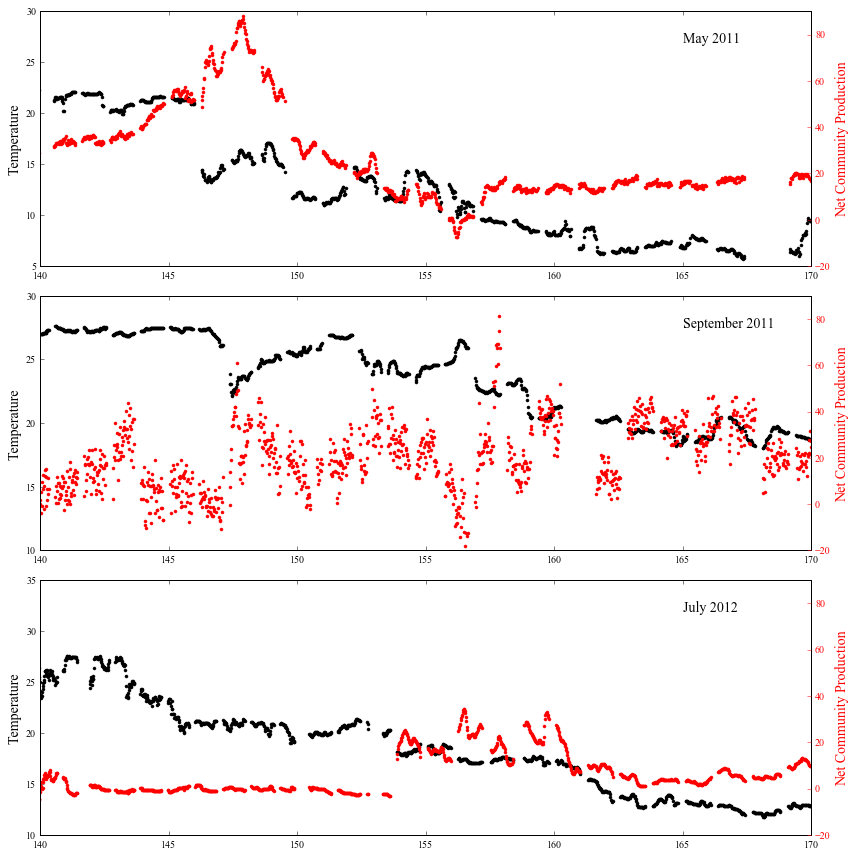

In [26]:
fig2, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (12, 12), dpi = 300)

ax1.plot(Tok1['Lon'], Tok1['T'], '.k')
ax4 = ax1.twinx()
ax4.plot(Tok1['Lon'], Tok1['Air-sea flux'], '.r')
ax1.set_xlim([140, 170])
ax1.set_ylim([5, 30])
ax4.set_ylim([-20, 90])
ax1.text(165, 27,'May 2011', fontsize = 14)

ax1.set_ylabel('Temperature', color='k', fontsize = 14)
ax4.set_ylabel('Net Community Production', color= 'r', fontsize = 14)
ax4.tick_params(colors='r')

ax2.plot(Tok3['Lon'], Tok3['T'], '.k')
ax5 = ax2.twinx()
ax5.plot(Tok3['Lon'], Tok3['Air-sea flux'], '.r')
ax2.set_xlim([140, 170])
ax2.set_ylim([10, 30])
ax5.set_ylim([-20, 90])
ax2.text(165, 27.5,'September 2011', fontsize = 14)

ax2.set_ylabel('Temperature', color='k', fontsize = 14)
ax5.set_ylabel('Net Community Production', color= 'r', fontsize = 14)
ax5.tick_params(colors='r')

ax3.plot(Tian['Lon'], Tian['T'], '.k')
ax6 = ax3.twinx()
ax6.plot(Tian['Lon'], Tian['Air-sea flux'], '.r')
ax3.set_xlim([140, 170])
ax3.set_ylim([10, 35])
ax6.set_ylim([-20, 90])
ax3.text(165, 32,'July 2012', fontsize = 14)

ax3.set_ylabel('Temperature', color='k', fontsize = 14)
ax6.set_ylabel('Net Community Production', color= 'r', fontsize = 14)
ax6.tick_params(colors='r')
ax6.set_xlabel('Longitude', fontsize = 14)

plt.show()

#fig2.savefig('../figures/uway_NCP_sst_MJS.png', dpi = 300)